# REG Capacity vs. Demand

Plots the historic and forecasted future project demand vs. team capacity for REG. This plot now uses only Forecast data with the exception of the available capacity from University Partner institutes, which is loaded from the file `wimbledon/vis/reg_capacity.csv`.

In Forecast:
* People should be allocated to the UNAVAILABLE project at 1 FTE (8hrs/day) to indicate their start and end dates, as well as fractional allocations for anyone who is available for less than 1 FTE for a period (if someone's long-term default allocation to REG is less than 1 FTE that should be changed using the capacity parameter in their profile instead).

* People should have one role out of "REG Associate", "REG Permanent", "REG FTC" (fixed term contract) and "University Partner" in their profile.

* Any team member on Forecast that should not be billable/allocated to projects, e.g. Fast Streamers, Project Managers, should have their capacity set to 0 hours per week in their profile.

* Unconfirmed project demand (e.g. projects with funder) can be indicated by allocating them to either the "Unconfirmed 01" or "Unconfirmed 02" placeholders. Similarly, projects that have been deferred can be indicated using the "Deferred" placeholder.

In [1]:
from wimbledon.vis import Visualise
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
start_date = pd.datetime(2017,4,1)
end_date = pd.datetime(2022,3,31)
today = pd.datetime.now()

start_date = pd.datetime(2019,7,15)
end_date = pd.datetime(2020,8,13)

resample_freq = 'MS'

In [3]:
start_date.year
pd.datetime(start_date.year, start_date.month, 1)

datetime.datetime(2019, 7, 1, 0, 0)

### Get Forecast Data

In [3]:
# set true if you want to query the Forecast API and update the database
# with the latest data.
# set false if you're happy with the current status of the database and
# don't want to wait for the update.
update_db = True

vis = Visualise(with_tracked_time=False,
                update_db=update_db)

### Plot Demand vs. Capacity

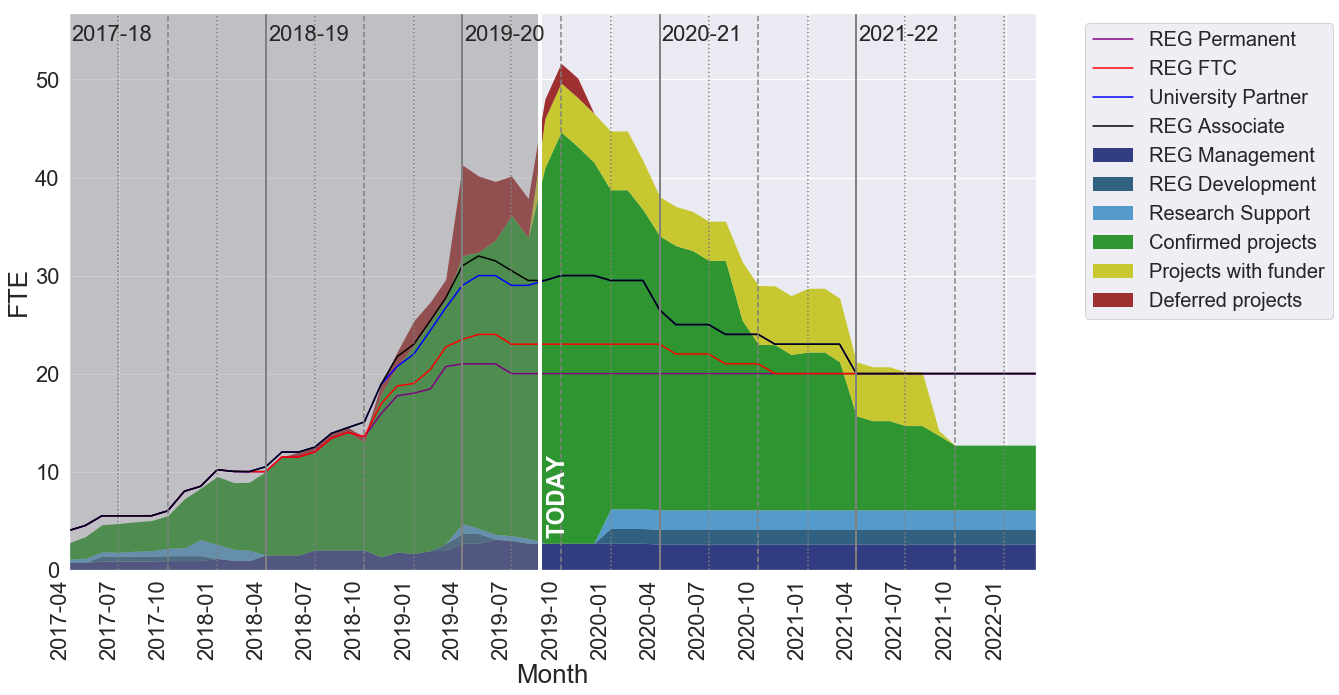

In [5]:
vis.plot_demand_vs_capacity(start_date=start_date, 
                            end_date=end_date, 
                            freq=resample_freq,
                            today=today)

# save figure
plt.tight_layout()
plt.savefig('../data/figs/demand_vs_capacity.png',dpi=300)

### Table Demand vs. Client

In [6]:
client_meanfte = vis.table_client_demand(start_date=start_date, end_date=end_date)

display(client_meanfte)

# save table
client_meanfte.to_csv('../data/figs/demand_per_client.csv')

2017-04-01  2018-04-01  \
Artifical Intelligence                              0.0         0.0   
Data science at scale                               0.2         1.1   
Data science for science and the humanities         0.0         1.5   
Data-centric engineering                            0.8         2.8   
Defence and security                                1.7         3.2   
External                                            0.0         0.0   
Finance and economics                               0.1         0.3   
Health                                              0.4         0.9   
Public Policy                                       0.1         0.4   
REG Development Work                                0.3         0.1   
REG Management                                      0.9         1.8   
REG Support                                         0.8         0.0   
SPF                                                 0.0         0.0   
Tools, Practices, and Systems                       0.4         2.6   
Turing research core                                0.5         1.3   
Urban analytics                                     0.0         0.7   

                                             2019-04-01  2020-04-01  \
Artifical Intelligence                              0.1         0.0   
Data science at scale                               0.0         0.0   
Data science for science and the humanities         3.4         2.1   
Data-centric engineering                            4.8         5.4   
Defence and security                                4.5         2.0   
External                                            0.0         0.0   
Finance and economics                               0.3         0.0   
Health                                              2.0         1.4   
Public Policy                                       0.3         0.0   
REG Development Work                                0.5         1.5   
REG Management                                      2.8         2.6   
REG Support                                         0.8         2.0   
SPF                                                 1.0         1.0   
Tools, Practices, and Systems                       6.1         5.2   
Turing research core                                9.4         3.6   
Urban analytics                                     1.7         0.0   

                                             2021-04-01  
Artifical Intelligence                              0.0  
Data science at scale                               0.0  
Data science for science and the humanities         1.6  
Data-centric engineering                            0.5  
Defence and security                                2.0  
External                                            0.0  
Finance and economics                               0.0  
Health                                              0.5  
Public Policy                                       0.0  
REG Development Work                                1.5  
REG Management                                      2.6  
REG Support                                         2.0  
SPF                                                 0.0  
Tools, Practices, and Systems                       3.0  
Turing research core                                0.0  
Urban analytics                                     0.0

## TODO
### High priority
1. **Demand / Capacity mismatch before 2018**
1. **Can we be confident 40 FTE is expected long run average? Perhaps x-FTE per programme (based on current less TF demand) + x-FTE per partner uni (support + TF demand + proj-specific demand)**

### Medium priority
1. **Add Scottish Enterprise demand back in time**
1. **Extend Third-party and Edinburgh Safe Haven capacity if demand is solid (check with JH). Should this be TPS or Hut23 project? If Hut23 move REG demand from June to this project.**
1. **Add AI programme demand?**

### Low priority
1. Split client table by funder.